In [13]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import models
import numpy as np

In [14]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


In [15]:
import pandas as pd
df= pd.read_csv("")

In [16]:
df

,Unnamed: 0,content,label
0,0,covid 19 cases going testing going,0
1,1,every election year disease sars 2004 avian fl...,0
2,2,paid rent march april got give money back,0
3,3,dr fauci reason wearing mask,0
4,4,drinking boiled garlic water cure covid 19,0
...,...,...,...
18999,21091,bill gates said covid 19 vaccine could kill 70...,0
19000,21093,bill gates said covid 19 vaccine permanently c...,0
19001,21094,covid 19 vaccine candidates insert microchips ...,0
19002,21095,image claims chroma screen panels used make co...,0


In [17]:
from sklearn.model_selection import train_test_split
x = df.content.values
x = [str (item) for item in x]
y = df.label.values
y = np.array(y)
x = np.array(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=True, random_state=1)

In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# from sklearn.metrics.pairwise import cosine_similarity


In [20]:
# Modelling

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
# Experiment with different dropout rate
layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) #pooled output is the encoded output
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

# Use inputs and outputs for final model construction
model = tf.keras.Model(inputs=[text_input], outputs = [layer])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      {'default': (None, 7 109482241   keras_layer_2[0][0]              
                                                                 keras_layer_2[0][1]              
                                                                 keras_layer_2[0][2]              
____________________________________________________________________________________________

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

# experiment with different optimisers
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
from keras.callbacks import EarlyStopping
x_train = np.array(x_train)
model.fit(x_train,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
84/84 [==============================] - 1542s 18s/step - loss: 0.6827 - accuracy: 0.5811 - precision: 0.4939 - recall: 0.2455 - val_loss: 0.6200 - val_accuracy: 0.6813 - val_precision: 0.7025 - val_recall: 0.3838


In [23]:
model.evaluate(x_test, y_test)

179/179 [==============================] - 685s 4s/step - loss: 0.6147 - accuracy: 0.6940 - precision: 0.7242 - recall: 0.4023


[0.6146737933158875,
 0.6939670443534851,
 0.7242447733879089,
 0.40232357382774353]

In [24]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, ..., 0, 0, 0])

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[3022,  356],
       [1389,  935]], dtype=int64)

Text(33.0, 0.5, 'Actual')

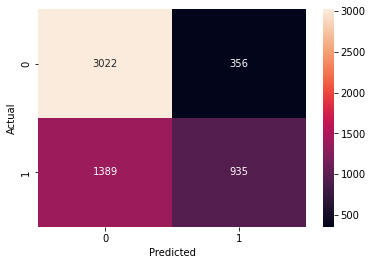

In [27]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.69      0.89      0.78      3378
           1       0.72      0.40      0.52      2324

    accuracy                           0.69      5702
   macro avg       0.70      0.65      0.65      5702
weighted avg       0.70      0.69      0.67      5702

